In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys, os, glob, csv, re
import string, math, numpy
import os
import logging
from matplotlib import pyplot
import matplotlib

In [4]:
pyplot.style.use('dark_background')
logging.basicConfig(level=logging.INFO)

In [5]:
try:
    from ltrack import config
    import ltrack.lineage.inference_params as inference_params
    import ltrack.lineage.file_parser as file_parser
    from ltrack.lineage.fitness_estimator import interval_endpoints as interval_endpoints
except ImportError:
    print("Please install the LineageTracking package by running the command line 'pip install .' in the lineage_tracking repository's root directory.")
    raise
except: raise

In [6]:
project_name = os.path.basename(os.getcwd())

In [7]:
# look only at lineages within specified size range
drifting_lineage_size_range = inference_params.drifting_lineage_size_range

In [8]:
INTERVALS_PER_EPOCH = inference_params.INTERVALS_PER_EPOCH
EVOLUTION_INTERVALS_PER_EPOCH = inference_params.EVOLUTION_INTERVALS_PER_EPOCH
NUMBER_OF_EPOCHS = inference_params.NUMBER_OF_EPOCHS

logging.info('INTERVALS_PER_EPOCH = {}'.format(INTERVALS_PER_EPOCH))
logging.info('NUMBER_OF_EPOCHS = {}'.format(NUMBER_OF_EPOCHS))

INFO:root:INTERVALS_PER_EPOCH = 2
INFO:root:NUMBER_OF_EPOCHS = 5


In [9]:
population = project_name

In [10]:
timepoints, data, counts = file_parser.get_data(
    population,
    config.barcode_data_root_directory,
    as_matrix = True
)

INFO:root:Processing population LT_5epochs.
INFO:root:Reading files.
INFO:root:Reading fitness inferences complete.


In [11]:
[d.shape for d in data]

[(7222, 10), (7222, 8), (7222, 6), (7222, 4), (7222, 2)]

In [12]:
len(counts)

10

In [14]:
count_data = []
begin = 0
for i in range(0,len(data)):
    print(begin)
    count_data.append(data[i]*counts[begin:])
    begin += INTERVALS_PER_EPOCH

0
2
4
6
8


In [15]:
max_barcode = config.max_barcode[population]
# sort count data on min size in first epoch

In [16]:
arrinds= [numpy.argsort(numpy.min(count_data[i].T[:INTERVALS_PER_EPOCH],axis = 0)) for i in range(0,len(data))]
sorted_mins = [numpy.min(count_data[i].T[:INTERVALS_PER_EPOCH],axis = 0)[arrinds[i][::-1]] for i in range(0,len(data))]
sorted_count_data = [count_data[i][arrinds[i][::-1]] for i in range(0,len(data))]

In [17]:
logging.info('Fitting kappas.')

kappas = numpy.zeros(len(timepoints[0]))
kappa_errors = numpy.zeros(len(timepoints[0]))
ns = numpy.zeros(len(timepoints[0]))

INFO:root:Fitting kappas.


In [18]:
for timepoint in range(0,max_barcode*INTERVALS_PER_EPOCH-1):
#     for timepoint in range(0,NUMBER_OF_EPOCHS*INTERVALS_PER_EPOCH-1):

    epoch = timepoint // INTERVALS_PER_EPOCH
    t = timepoint % INTERVALS_PER_EPOCH

    counts_before, counts_after = sorted_count_data[epoch].T[t],sorted_count_data[epoch].T[t+1]
    counts_before = numpy.asarray(counts_before,dtype = float)
    counts_after = numpy.asarray(counts_after,dtype = float)

    before_filter = numpy.logical_and(counts_before <= drifting_lineage_size_range[1], counts_before >= drifting_lineage_size_range[0])
    counts_after = counts_after[before_filter]
    counts_before = counts_before[before_filter]
    scaled_counts_before = counts_before * counts[INTERVALS_PER_EPOCH*epoch+t+1]/counts[INTERVALS_PER_EPOCH*epoch+t]
    n = len(counts_before)

    kappas[INTERVALS_PER_EPOCH*epoch + t] = 2* ((numpy.sqrt(counts_after) - numpy.sqrt(scaled_counts_before))**2).sum()/n
    kappa_errors[INTERVALS_PER_EPOCH*epoch+t] =kappas[INTERVALS_PER_EPOCH*epoch + t]* numpy.sqrt(2./n)
    ns[INTERVALS_PER_EPOCH*epoch+t] = n

In [19]:
# Fix zeroes as these will cause DivideByZeros later.
zero_kappas =  kappas==0.0
kappas[zero_kappas] = 100.0
kappa_errors[zero_kappas] = 10.0
kappa_CI_lower = kappas - 2 *kappa_errors
kappa_CI_upper = kappas + 2* kappa_errors

In [20]:
kappas.shape


(10,)

In [21]:
len(timepoints[0])

10

<ErrorbarContainer object of 3 artists>

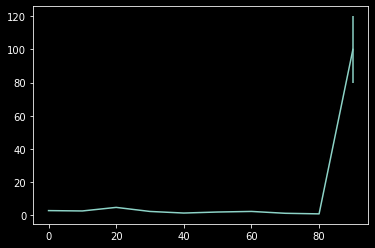

In [22]:
fig, ax = pyplot.subplots()
ax.errorbar(x=timepoints[0], y=kappas, yerr=2*kappa_errors)

In [23]:
with open(config.error_model_directory+'%s-kappas.tsv' % (population), 'w') as csvfile:
    out_writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    out_writer.writerow(timepoints[0][1:])
    out_writer.writerow(["{0:.2f}".format(x) for x in kappas])
    out_writer.writerow(["{0:.2f}".format(x) for x in kappa_CI_lower])
    out_writer.writerow(["{0:.2f}".format(x) for x in kappa_CI_upper])
    out_writer.writerow(["{0:.2f}".format(x) for x in ns])

In [24]:
with open(config.error_model_directory+'%s-kappas-barcoding.tsv' % (population), 'w') as csvfile:
    out_writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    out_writer.writerow(timepoints[0][INTERVALS_PER_EPOCH::INTERVALS_PER_EPOCH])
    out_writer.writerow(["{0:.2f}".format(x) for x in kappas[EVOLUTION_INTERVALS_PER_EPOCH::INTERVALS_PER_EPOCH]])
    out_writer.writerow(["{0:.2f}".format(x) for x in kappa_CI_lower[EVOLUTION_INTERVALS_PER_EPOCH::INTERVALS_PER_EPOCH]])
    out_writer.writerow(["{0:.2f}".format(x) for x in ns[EVOLUTION_INTERVALS_PER_EPOCH::INTERVALS_PER_EPOCH]])